In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [2]:
#hyperfine reduced matrix element <F||d||F'>
def __Fg_d_Fe(Jg_d_Je, Fg, Fe, Jg, Je, I):
    return (
    Jg_d_Je * (-1)**(Fe+Jg+1+I) * 
        np.sqrt( (2*Fe+1)*(2*Jg+1) ) 
        * wigner_6j(Jg, Je, 1, Fe, Fg, I)
    )

In [3]:
#reduced matrix element <Jg||d||Je>
def __Jg_d_Je(omega_0, Jg, Je, tau):
    return np.sqrt(
        3*np.pi*epsilon0*hbar*c**3/omega_0**3/tau
        * (2*Je+1)/(2*Jg+1)
    )

In [4]:
def Rabi_clock(Fg, Fe, mg, me, d, pol):
    q = -(me-mg)
    Jg_d_Je = d
    
    CG_coeff = float(CG(Fe, me, 1, q, Fg, mg).doit())
    
    Eplus = pol * np.sqrt( intensity / 2 / epsilon0 / c)
    
    return (
    -2 * Jg_d_Je / hbar * Eplus * CG_coeff
    )
    

In [5]:
wH = 0.025e-3
wV = wH
P = 0.6*80e-3
intensity = 2*P/np.pi/wV/wH
d = 4.5*hbar

In [6]:
Rabi_clock(1/2, 1/2, 1/2, -1/2, 4.5*hbar,  1)/1e6/2/np.pi

0.11223749592894952

In [7]:
Rabi_clock(1/2, 1/2, 1/2, 1/2, 4.5*hbar,  1)/1e6/2/np.pi

-0.07936389447475771

In [133]:
_lambda = 578e-9
omega_r = 2*np.pi*8e3
m = 171*u
tau = 22

k = 2*np.pi/_lambda #momentum kick 
x0 = np.sqrt(hbar/2/m/omega_r) #oscillator length
LambDicke = x0*k #Lamb-Dicke parameters
print('Lamb-Dicke parameter (eta): ', LambDicke)
print('eta^2 (2n+1): ', LambDicke**2, '(2n+1)')
print('Max n for Lamb-Dicke regime: n = ', floor(((1/LambDicke**2)-1)/2))

Lamb-Dicke parameter (eta):  0.6607201946347716
eta^2 (2n+1):  0.4365511755982105 (2n+1)
Max n for Lamb-Dicke regime: n =  0


In [134]:
N=20 #keep HO states up to N 

one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)
ground = fock(N, 0)

a = qutip.tensor(destroy(N), identity(4))
adag = qutip.tensor(create(N), identity(4))

sig_11 = qutip.tensor(identity(N),one*one.dag())
sig_22 = qutip.tensor(identity(N),two*two.dag())
sig_33 = qutip.tensor(identity(N),three*three.dag())
sig_44 = qutip.tensor(identity(N),four*four.dag())

sig_14 = qutip.tensor(identity(N),one*four.dag())
sig_41 = qutip.tensor(identity(N),four*one.dag())

sig_13 = qutip.tensor(identity(N),one*three.dag())
sig_31 = qutip.tensor(identity(N),three*one.dag())

sig_24 = qutip.tensor(identity(N),two*four.dag())
sig_42 = qutip.tensor(identity(N),four*two.dag())

sig_23 = qutip.tensor(identity(N),two*three.dag())
sig_32 = qutip.tensor(identity(N),three*two.dag())

In [135]:
psi0 = (two)
psii = (three)
rhoi = psii*psii.dag()
i_proj = qutip.tensor(identity(N), rhoi)
ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

In [136]:
T=1e-6 #initial temperature
omega_r_deep = 2*np.pi*63e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0 = qutip.tensor(thermal_dm(N, n_start), psi0*psi0.dag()) #start in up thermal state
print(isherm(rho0))
print('n_start: ', n_start)
print('ground state population', (rho0*ground_proj).tr())

True
n_start:  0.05111530367346818
ground state population 0.9513704124610985


In [137]:
B = 6.8*4.8e-4/20 #magnetic field in T
print('Magnetic field B', B*1e4, 'G')

delta_Ne = -2*np.pi*582*B*1e4 #excited
delta_Ng = -2*np.pi*375*B*1e4 #ground
Fg=1/2
Fe=1/2

Magnetic field B 1.6320000000000001 G


In [142]:
dt = 1e-7
t_ls = np.arange(0, 0.3e-3, dt)

In [143]:
#diagonal terms
diag_1 = -delta_Ng

diag_2 = delta_Ng

diag_3 = -delta_Ne

diag_4 = delta_Ne

In [144]:
def Hp_coeff(t, args):
    return np.exp(1j*delta*t)

def Hm_coeff(t, args):
    return np.exp(-1j*delta*t)

In [145]:
phi = -np.pi/2
angle_pol = (np.pi/4) 
impurity = 2e-2

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

xb = np.array([np.sqrt(1-impurity),impurity,0])
yb = np.array([-impurity,np.sqrt(1-impurity),0])
zb = np.array([0,0,1])

polarization = (np.cos(angle_pol)*xb+np.sin(angle_pol)*np.exp(-1j*phi)*zb)

pi_pol = y
sigp_pol = 1/np.sqrt(2)*(z-1j*x)
sigm_pol = -1/np.sqrt(2)*(z+1j*x)

#off-diagonal terms
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_14 = np.conjugate(offdiag_41)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_24 = np.conjugate(offdiag_42)
offdiag_23 = np.conjugate(offdiag_32)

delta = -(delta_Ng+delta_Ne)

H0 = diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

Hm = omega_r*(adag*a + 1/2)

H1_diag = H0+Hm

H1_offdiag = (offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                       offdiag_24*sig_24 + offdiag_23*sig_23)*( (1j*LambDicke*(adag+a)).expm())

H1_conj = (offdiag_31*sig_31 + offdiag_41*sig_41
                                        + offdiag_42*sig_42 + offdiag_32*sig_32)*( (-1j*LambDicke*(adag+a)).expm())

c_ops = []

options = qutip.solver.Options(nsteps=100000)

output = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], rho0, t_ls, 
                      c_ops, options=options)

In [146]:
offdiag_41/offdiag_32, 1/200

((0.005050633883346561-3.061538899378514e-17j), 0.005)

In [147]:
rho_ls = output.states

P = [(i_proj*rho).tr()  for rho in rho_ls]
Pg = [(ground_proj*rho).tr()  for rho in rho_ls]

max fidelity: 0.9993
7.599999999999999e-05 1e-07


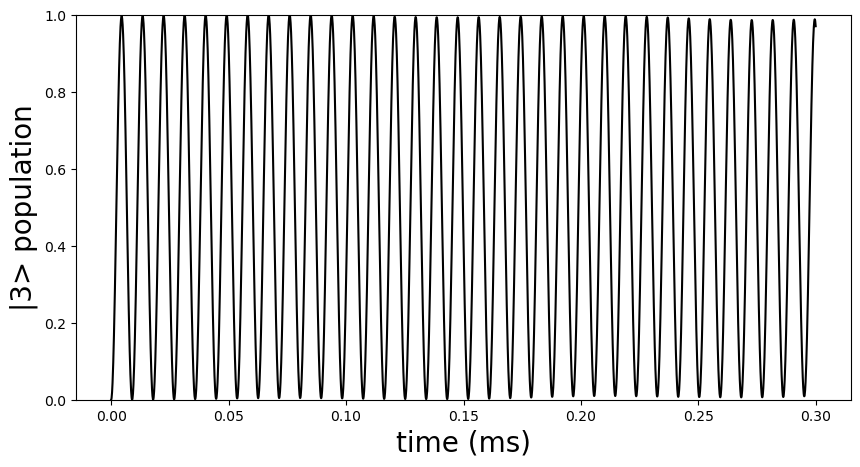

In [149]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(t_ls*1e3, np.array(P), color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'|3> population', fontsize=20)
print('max fidelity: %.4f' %np.max(abs(np.array(P))))
axes.set_ylim(0,1)

pi_time_idx = np.argwhere(abs(np.array(P))==np.max(abs(np.array(P))))
pi_time = t_ls[pi_time_idx][0][0]
print(pi_time, dt)
#axes.set_ylim(0.99, 1)

Text(0, 0.5, 'motional n=0 population')

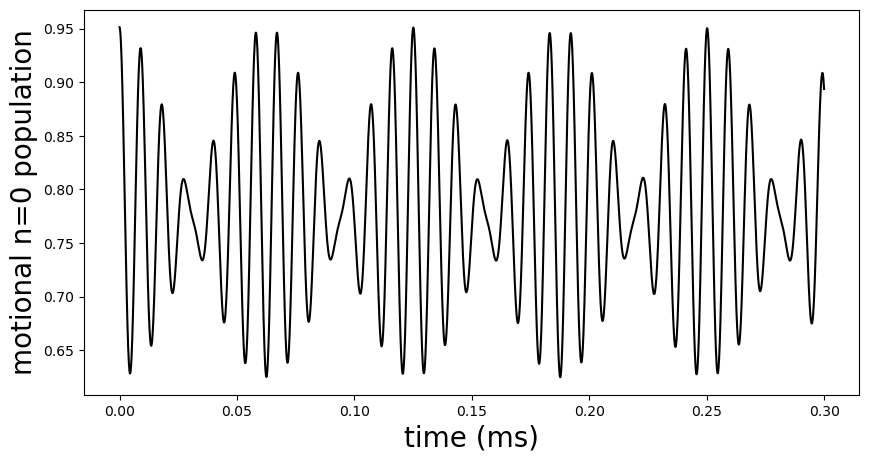

In [150]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(t_ls*1e3, Pg, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'motional n=0 population', fontsize=20)
#axes.set_ylim(0.6, 1)
#axes.set_xlim(0, 0.01)

# Wait and recovery

In [81]:
psi0 = (two)
rhoi = two*two.dag()
i_proj = qutip.tensor(identity(N), rhoi)
ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

In [87]:
pi_time = 4.47e-6

phi = -np.pi/2
angle_pol = (np.pi/4) 
impurity = 2e-2

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

xb = np.array([np.sqrt(1-impurity),impurity,0])
yb = np.array([-impurity,np.sqrt(1-impurity),0])
zb = np.array([0,0,1])

polarization = (np.cos(angle_pol)*xb+np.sin(angle_pol)*np.exp(-1j*phi)*zb)

pi_pol = y
sigp_pol = 1/np.sqrt(2)*(z-1j*x)
sigm_pol = -1/np.sqrt(2)*(z+1j*x)

#off-diagonal terms
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_14 = np.conjugate(offdiag_41)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_24 = np.conjugate(offdiag_42)
offdiag_23 = np.conjugate(offdiag_32)

delta = -(delta_Ng+delta_Ne)

H0 = diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

Hm = omega_r*(adag*a + 1/2)

H1_diag = H0+Hm

H1_offdiag = (offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                       offdiag_24*sig_24 + offdiag_23*sig_23)*( (1j*LambDicke*(adag+a)).expm())

H1_conj = (offdiag_31*sig_31 + offdiag_41*sig_41
                                        + offdiag_42*sig_42 + offdiag_32*sig_32)*( (-1j*LambDicke*(adag+a)).expm())

c_ops = []

options = qutip.solver.Options(nsteps=100000)

output = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], rho0, t_ls, 
                      c_ops, options=options)


dt = 1e-8
tpi_ls = np.arange(0, pi_time, dt)

output0 = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], rho0, tpi_ls, 
                      c_ops, options=options)


twait_ls = np.linspace(6.1e-3, 6.3e-3, 50)

result_ls = []

Hm_wait = omega_r_deep*(adag*a + 1/2)

H1wait_diag = H0+Hm

i = 0
for tw in twait_ls:
    rho1 = output0.states[-1]
    dtw = 1/omega_r_deep/20
    tw_ls = np.arange(tpi_ls[-1], tpi_ls[-1]+tw, dtw)
    output1 = mesolve(H1wait_diag, rho1, tw_ls, c_ops, options=options)
    
    rho2 = output1.states[-1]
    
    tw2_ls = np.arange(tpi_ls[-1]+tw, 2*tpi_ls[-1]+tw, dt)
    
    output2 = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], rho2, tw2_ls, 
                      c_ops, options=options)
    #print(output2.states[-1])
    result_ls.append(output2.states[-1])
    print(i)
    i += 1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [88]:
#rho_ls = output.states

P = [(i_proj*rho).tr()  for rho in result_ls]
Pg = [(ground_proj*rho).tr()  for rho in result_ls]

max fidelity: 0.99974
min fidelity: 0.9812


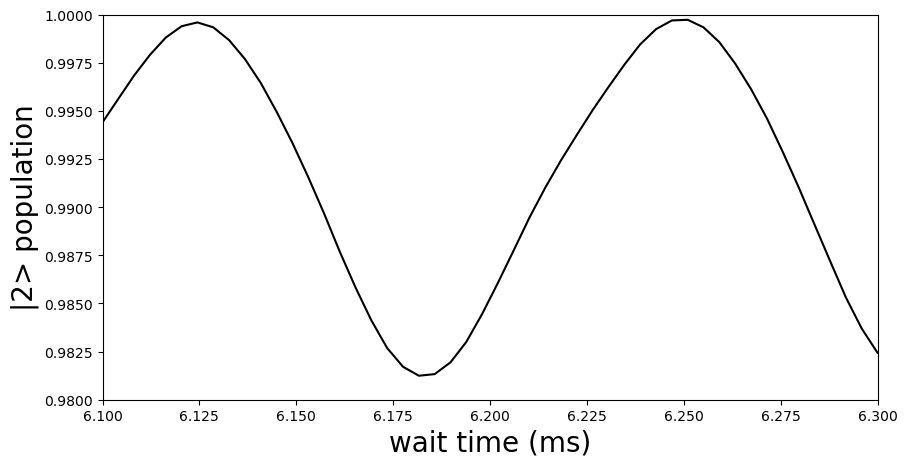

In [90]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(twait_ls*1e3, np.array(P), color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'wait time (ms)', fontsize=20)
axes.set_ylabel(r'|2> population', fontsize=20)
print('max fidelity: %.5f' %np.max(abs(np.array(P))))
axes.set_ylim(0.98,1)
axes.set_xlim(6.1,6.3)
print('min fidelity: %.4f' %np.min(abs(np.array(P))))

max fidelity: 0.9997


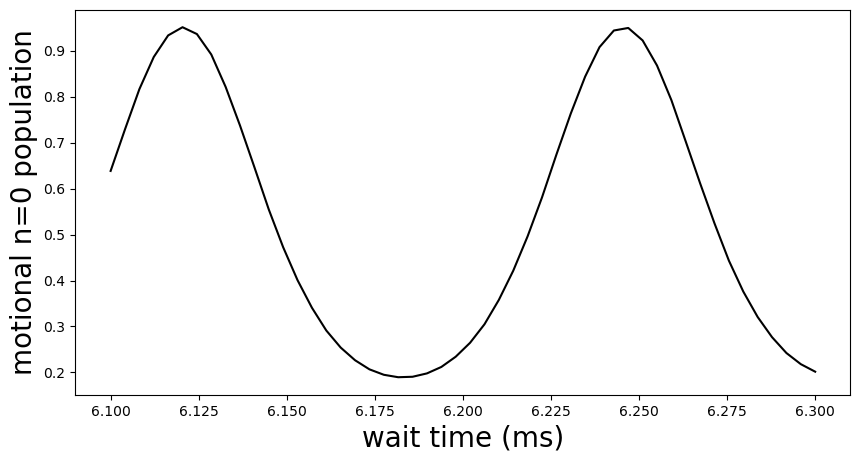

In [91]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(twait_ls*1e3, np.array(Pg), color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'wait time (ms)', fontsize=20)
axes.set_ylabel(r'motional n=0 population', fontsize=20)
print('max fidelity: %.4f' %np.max(abs(np.array(P))))

# Trap frequency variation

In [154]:
N=20 #keep HO states up to N 

one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)
ground = fock(N, 0)

a = qutip.tensor(destroy(N), identity(4))
adag = qutip.tensor(create(N), identity(4))

sig_11 = qutip.tensor(identity(N),one*one.dag())
sig_22 = qutip.tensor(identity(N),two*two.dag())
sig_33 = qutip.tensor(identity(N),three*three.dag())
sig_44 = qutip.tensor(identity(N),four*four.dag())

sig_14 = qutip.tensor(identity(N),one*four.dag())
sig_41 = qutip.tensor(identity(N),four*one.dag())

sig_13 = qutip.tensor(identity(N),one*three.dag())
sig_31 = qutip.tensor(identity(N),three*one.dag())

sig_24 = qutip.tensor(identity(N),two*four.dag())
sig_42 = qutip.tensor(identity(N),four*two.dag())

sig_23 = qutip.tensor(identity(N),two*three.dag())
sig_32 = qutip.tensor(identity(N),three*two.dag())

In [155]:
psi0 = (two)
psii = (two)
rhoi = psii*psii.dag()
i_proj = qutip.tensor(identity(N), rhoi)
ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

In [167]:
omega_r0 = 2*np.pi*8e3

Nresult_ls = []
omega_r_ls = []

Ntraj = 48
for count in range(Ntraj):
    omega_r = np.random.normal(loc=omega_r0, scale=5e-2*omega_r0) 
    omega_r_ls.append(omega_r)
    print(count)
    _lambda = 578e-9
    m = 171*u
    tau = 22

    k = 2*np.pi/_lambda #momentum kick 
    x0 = np.sqrt(hbar/2/m/omega_r) #oscillator length
    LambDicke = x0*k #Lamb-Dicke parameters

    T=1e-6 #initial temperature
    omega_r_deep = omega_r*63/8.
    n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
    rho0 = qutip.tensor(thermal_dm(N, n_start), psi0*psi0.dag()) #start in up thermal state

    pi_time = 4.47e-6

    phi = -np.pi/2
    angle_pol = (np.pi/4) 
    impurity = 2e-2

    ## polarization ##
    ##################

    #basis
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    z = np.array([0,0,1])

    xb = np.array([np.sqrt(1-impurity),impurity,0])
    yb = np.array([-impurity,np.sqrt(1-impurity),0])
    zb = np.array([0,0,1])

    polarization = (np.cos(angle_pol)*xb+np.sin(angle_pol)*np.exp(-1j*phi)*zb)

    pi_pol = y
    sigp_pol = 1/np.sqrt(2)*(z-1j*x)
    sigm_pol = -1/np.sqrt(2)*(z+1j*x)

    #off-diagonal terms
    offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
    offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
    offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
    offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

    offdiag_14 = np.conjugate(offdiag_41)
    offdiag_13 = np.conjugate(offdiag_31)
    offdiag_24 = np.conjugate(offdiag_42)
    offdiag_23 = np.conjugate(offdiag_32)

    delta = -(delta_Ng+delta_Ne)

    H0 = diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

    Hm = omega_r_deep*(adag*a + 1/2)

    H1_diag = H0+Hm

    H1_offdiag = (offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                           offdiag_24*sig_24 + offdiag_23*sig_23)*( (1j*LambDicke*(adag+a)).expm())

    H1_conj = (offdiag_31*sig_31 + offdiag_41*sig_41
                                            + offdiag_42*sig_42 + offdiag_32*sig_32)*( (-1j*LambDicke*(adag+a)).expm())

    c_ops = []


    dt = 1e-8
    tpi_ls = np.arange(0, pi_time, dt)

    output0 = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], rho0, tpi_ls, 
                          c_ops, options=options)


    twait_ls = np.linspace(1.1e-3, 1.3e-3, 10)

    result_ls = []

    Hm_wait = omega_r*(adag*a + 1/2)

    H1wait_diag = H0+Hm

    i = 0
    for tw in twait_ls:
        rho1 = output0.states[-1]
        dtw = 1/omega_r_deep/20
        tw_ls = np.arange(tpi_ls[-1], tpi_ls[-1]+tw, dtw)
        
        gamma1 = 1/440e-3/5
        gamma2 = 1/440e-3*4/5
        
        c_ops = [gamma1*sig_14, gamma1*sig_23, gamma2*sig_13, gamma2*sig_24]
        
        output1 = mesolve(H1wait_diag, rho1, tw_ls, c_ops, options=options)

        rho2 = output1.states[-1]

        tw2_ls = np.arange(tpi_ls[-1]+tw, 2*tpi_ls[-1]+tw, dt)
        c_ops = []

        output2 = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], rho2, tw2_ls, 
                          c_ops, options=options)
        #print(output2.states[-1])
        result_ls.append(output2.states[-1])

        i += 1
        
    Nresult_ls.append(result_ls)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [164]:
#rho_ls = output.states

P = np.mean([[(i_proj*rho).tr()  for rho in result_ls] for result_ls in Nresult_ls], axis=0)
Pg = np.mean([[(ground_proj*rho).tr()  for rho in result_ls] for result_ls in Nresult_ls], axis=0)

max fidelity: 0.71894
min fidelity: 0.6701
avg fidelity: 0.6954


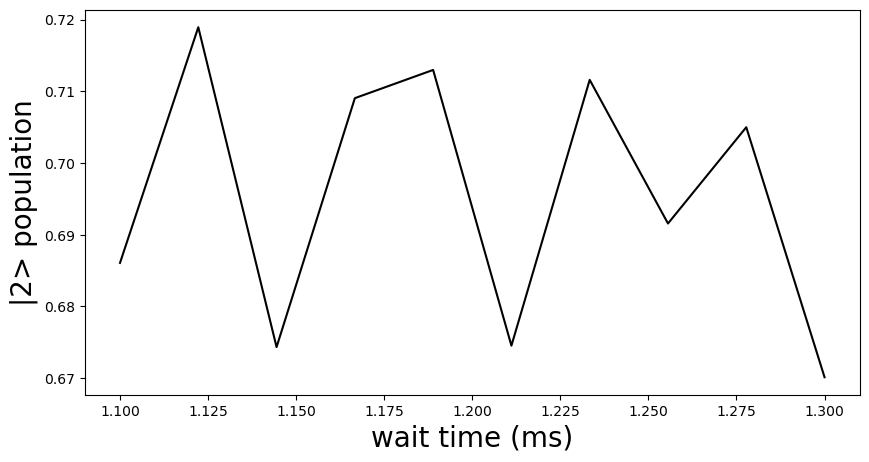

In [166]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(twait_ls*1e3, np.array(P), color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'wait time (ms)', fontsize=20)
axes.set_ylabel(r'|2> population', fontsize=20)
print('max fidelity: %.5f' %np.max(abs(np.array(P))))
#axes.set_ylim(0.982,0.999)
#axes.set_xlim(0.1,0.3)
print('min fidelity: %.4f' %np.min(abs(np.array(P))))
print('avg fidelity: %.4f' %np.mean(abs(np.array(P))))

max fidelity: 0.9913


(0.1, 1.0)

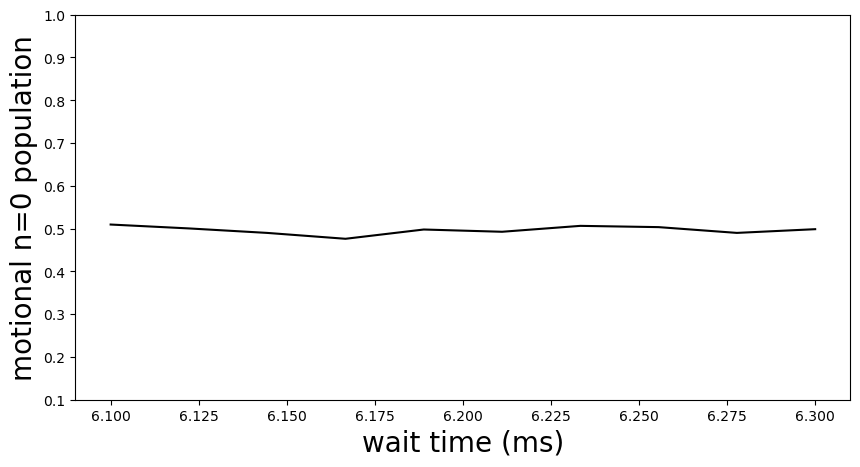

In [159]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(twait_ls*1e3, np.array(Pg), color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'wait time (ms)', fontsize=20)
axes.set_ylabel(r'motional n=0 population', fontsize=20)
print('max fidelity: %.4f' %np.max(abs(np.array(P))))
axes.set_ylim(0.1, 1)